### Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy import stats
from sktime.libs.vmdpy import VMD
from scipy.signal import hilbert
import torch.nn.functional as F
import torch

/tmp/ipykernel_1768089/3684719143.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from scipy.signal import butter, filtfilt # added
import numpy as np

# Calculate the repetition time (TR) depending on the site
def repetition_time(site):

    if 'Amsterdam-AMC' in site:
        TR = 2.375
    elif 'Amsterdam-VUmc' in site:
        TR = 1.8
    elif 'Barcelona-HCPB' in site:
        TR = 2
    elif 'Bergen' in site:
        TR = 1.8
    elif 'Braga-UMinho-Braga-1.5T' in site:
        TR = 2
    elif 'Braga-UMinho-Braga-1.5T-act' in site:
        TR = 2
    elif 'Braga-UMinho-Braga-3T' in site:
        TR = 1
    elif 'Brazil' in site:
        TR = 2
    elif 'Cape-Town-UCT-Allegra' in site:
        TR = 1.6
    elif 'Cape-Town-UCT-Skyra' in site:
        TR = 1.73
    elif 'Chiba-CHB' in site:
        TR = 2.3
    elif 'Chiba-CHBC' in site:
        TR = 2.3 
    elif 'Chiba-CHBSRPB' in site:
        TR = 2.5 
    elif 'Dresden' in site:
        TR = 0.8 
    elif 'Kyoto-KPU-Kyoto1.5T' in site:
        TR = 2.411 
    elif 'Kyoto-KPU-Kyoto3T' in site:
        TR = 2
    elif 'Kyushu' in site:
        TR = 2.5
    elif 'Milan-HSR' in site:
        TR = 2
    elif 'New-York' in site:
        TR = 1
    elif 'NYSPI-Columbia-Adults' in site:
        TR = 0.85
    elif 'NYSPI-Columbia-Pediatric' in site:
        TR = 0.85
    elif 'Yale-Pittinger-HCP-Prisma' in site:
        TR = 0.8
    elif 'Yale-Pittinger-HCP-Trio' in site:
        TR = 0.7
    elif 'Yale-Pittinger-Yale-2014' in site:
        TR = 2
    elif 'Bangalore-NIMHANS' in site:
        TR = 2 
    elif 'Barcelone-Bellvitge-ANTIGA-1.5T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-COMPULSE-3T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-PROV-1.5T' in site:
        TR = 2
    elif 'Barcelone-Bellvitge-RESP-CBT-3T' in site:
        TR = 2
    elif 'Seoul-SNU' in site:
        TR = 3.5
    elif 'Shanghai-SMCH' in site:
        TR = 3
    elif 'UCLA' in site:
        TR = 2
    elif 'Vancouver-BCCHR' in site:
        TR = 2
    elif 'Yale-Gruner' in site:
        TR = 2
    else:
        raise ValueError(f"Site '{site}' does not have a defined TR value in TR_mappings. Please add it.")

    return TR

In [3]:
def compute_imf_bandwidths(u, fs, threshold=0.05):
    """
    Compute the bandwidths of IMFs using the Fourier spectrum directly from VMD output.
    
    This version correctly extracts frequency bounds in Hz, avoiding the issue of 
    symmetric zero-centered results.
    
    Parameters:
    u (ndarray): IMFs (shape: K x N, where K is the number of IMFs, N is the time samples).
    fs (float): Sampling frequency of the time series (Hz).
    threshold (float): Power threshold for frequency support (default 1% of max power).

    Returns:
    dict: Band cutoffs in Hz as { 'imf1_lb': ..., 'imf1_hb': ..., ... }
    """
    K, N = u.shape  # Number of IMFs and time samples
    f_N = fs / 2  # Nyquist frequency
    freqs = np.fft.fftfreq(N, d=1/fs)  # Compute frequencies WITHOUT shifting
    positive_freqs = freqs[:N//2]  # Keep only positive frequencies
    band_cutoffs = {}

    for k in range(K):
        # Compute the Fourier Transform of the IMF
        U_k = np.fft.fft(u[k, :])
        power_spectrum = np.abs(U_k) ** 2

        # Normalize power and apply threshold
        power_threshold = threshold * np.max(power_spectrum)
        
        # Extract frequency support only from the positive range
        freq_support = positive_freqs[power_spectrum[:N//2] > power_threshold]

        if len(freq_support) > 0:
            f_min = np.min(freq_support)  # Minimum frequency with significant power
            f_max = np.max(freq_support)  # Maximum frequency with significant power
        else:
            f_min, f_max = 0, 0  # In case no significant power is detected

        # Store the frequency cutoffs
        band_cutoffs[f'imf{k+1}_lb'] = max(0, f_min)  # Ensure non-negative frequencies
        band_cutoffs[f'imf{k+1}_hb'] = min(f_N, f_max)  # Ensure does not exceed Nyquist

    return band_cutoffs

In [4]:
def bandpass_filter_2d(data, lowcut, highcut, fs, order=4):
    """
    Applies a Butterworth bandpass filter to each ROI in a 2D time-series dataset.
    
    Parameters:
    - data: numpy array of shape (#ROIs, #timepoints), where each row is a time series for one ROI.
    - lowcut: Lower cutoff frequency (Hz).
    - highcut: Upper cutoff frequency (Hz).
    - fs: Sampling frequency (Hz) = 1 / TR.
    - order: Order of the Butterworth filter (default = 4).

    Returns:
    - filtered_data: numpy array of the same shape as 'data' with filtered time series.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply filter to each ROI (row-wise)
    filtered_data = np.array([filtfilt(b, a, roi_signal) for roi_signal in data])

    return filtered_data

### Read data

In [104]:
# Example fMRI time-series data (timepoints x ROIs)
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy")
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Seoul-SNU_sub-DNO01LYH/Seoul-SNU_sub-DNO01LYH.npy")
# time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Brazil_sub-P00196820141124/Brazil_sub-P00196820141124.npy")

print(f"Data shape: {time_series_data.shape}")

FileNotFoundError: [Errno 2] No such file or directory: '/pscratch/sd/p/pakmasha/MBBN_data/Amsterdam-VUmc_sub-916002/Amsterdam-VUmc_sub-916002.npy'

In [12]:
y = time_series_data.T # [180, seq_len]
ts_length = y.shape[1]
TR = 3.5   # EDIT the TR
print(f"y shape: {y.shape}")

y shape: (316, 112)


### Fixed cutoffs

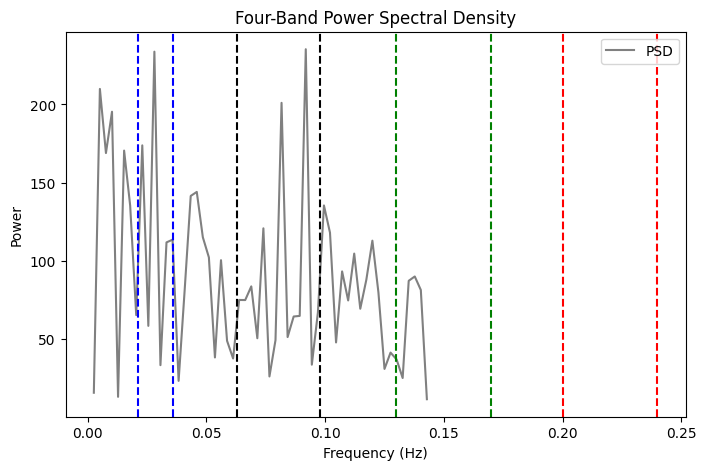

xdata.shape: (56,), ydata.shape: (56,)


In [13]:
sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec   

T = TimeSeries(sample_whole, sampling_interval=TR)
S_original = SpectralAnalyzer(T)

xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata, label='PSD', linewidth=1.5, color='gray')

# Add dashed vertical lines at f1 and f2
plt.axvline(x=0.24, color='red', linestyle='--')
plt.axvline(x=0.20, color='red', linestyle='--')            
plt.axvline(x=0.17, color='green', linestyle='--')
plt.axvline(x=0.13, color='green', linestyle='--')
plt.axvline(x=0.098, color='black', linestyle='--')
plt.axvline(x=0.063, color='black', linestyle='--')
plt.axvline(x=0.036, color='blue', linestyle='--')
plt.axvline(x=0.021, color='blue', linestyle='--')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("Four-Band Power Spectral Density")
# plt.grid(True, linestyle='--', alpha=0.7)
plt.grid(False)
plt.legend()
plt.show()

print(f"xdata.shape: {xdata.shape}, ydata.shape: {ydata.shape}")

Nyquist frequency: 0.14285714285714285


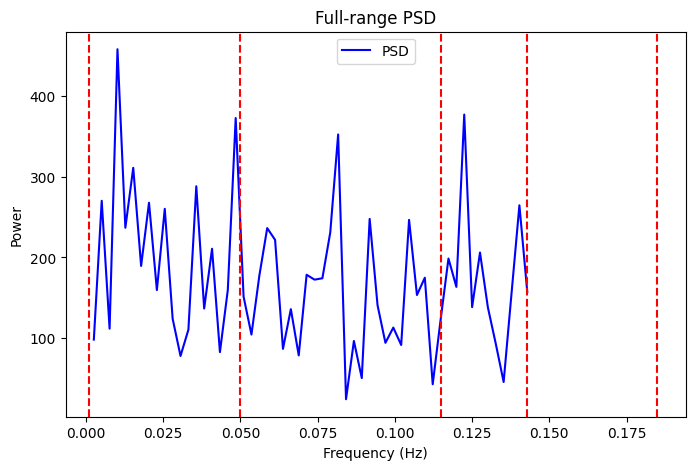

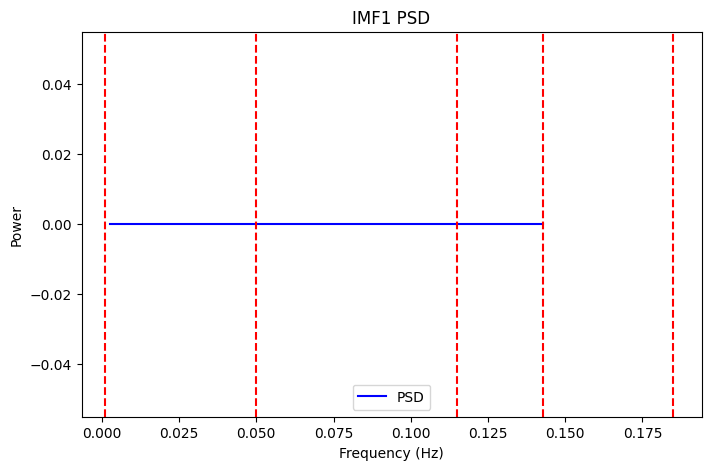

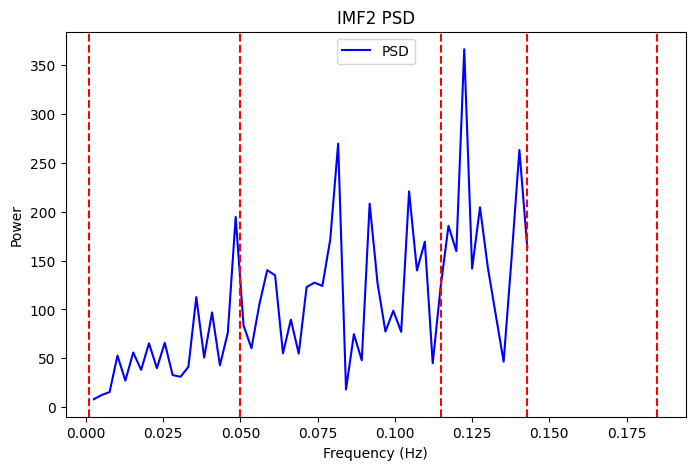

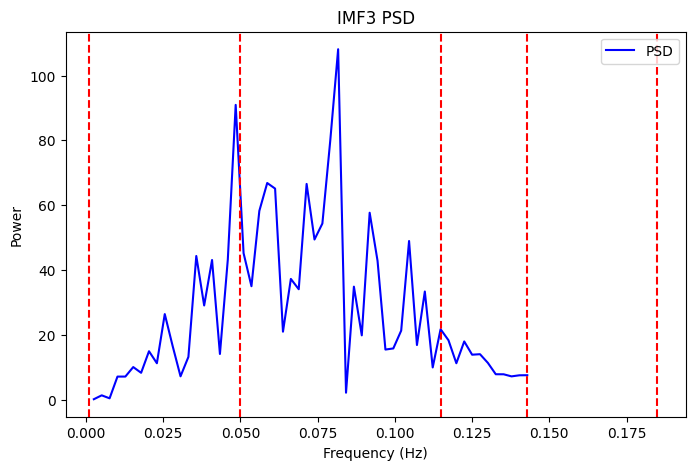

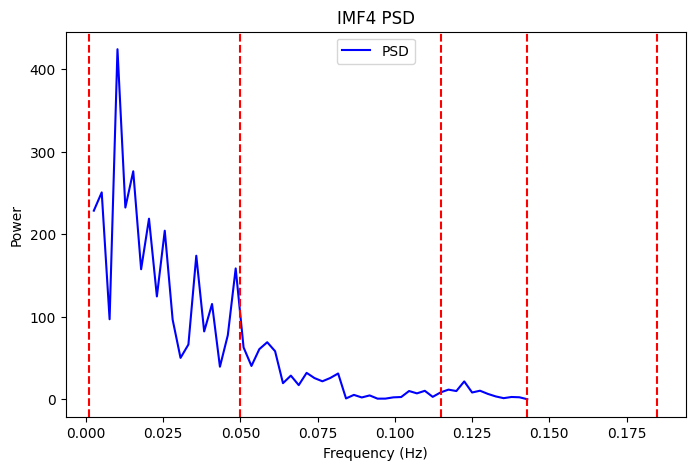

In [25]:
nyquist_freq = 1/(2*TR)
print(f"Nyquist frequency: {nyquist_freq}")

# Full-range time series
T = TimeSeries(y, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("Full-range PSD")
plt.grid(False)
plt.legend()
plt.show()

# VMD IMF1: 0.20-0.24 Hz
if nyquist_freq > 0.185:
    lower_bound = 0.185
    upper_bound = 1 / (2*TR)
    T1 = TimeSeries(y, sampling_interval=TR)  # creates a time-series object from y
    FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
    imf_1 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
    imf_2_4 = FA1.data-FA1.filtered_boxcar.data
else: # filter out the whole band
    T1 = TimeSeries(np.zeros(y.shape), sampling_interval=TR)
    FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
    imf_1 = T1  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
    imf_2_4 = y

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF1 PSD")
plt.grid(False)
plt.legend()
plt.show()


# VMD IMF2: 0.13-0.17 Hz
lower_bound = 0.115
upper_bound = max(0.185, nyquist_freq)
T1 = TimeSeries(imf_2_4, sampling_interval=TR)  # creates a time-series object from y
FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
imf_2 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
imf_3_4 = FA1.data-FA1.filtered_boxcar.data

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF2 PSD")
plt.grid(False)
plt.legend()
plt.show()

# VMD IMF3: 0.063- 0.098 Hz
lower_bound = 0.05
upper_bound = 0.115
T1 = TimeSeries(imf_3_4, sampling_interval=TR)  # creates a time-series object from y
S_original = SpectralAnalyzer(T1)
FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
imf_3 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
imf_4 = FA1.data-FA1.filtered_boxcar.data

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF3 PSD")
plt.grid(False)
plt.legend()
plt.show()


# VMD IMF4: 0.021-0.036 Hz
lower_bound = 0.001
upper_bound = 0.05
T1 = TimeSeries(imf_4, sampling_interval=TR)  # creates a time-series object from y
S_original = SpectralAnalyzer(T1)
FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
imf_4 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)

T = TimeSeries(FA1.filtered_boxcar.data, sampling_interval=TR)
S_original1 = SpectralAnalyzer(T)  # creates a spectral analyzer object for the time-series data T1
xdata = np.array(S_original1.spectrum_fourier[0][1:])
ydata = np.abs(S_original1.spectrum_fourier[1][:,1:])

plt.figure(figsize=(8, 5))
plt.plot(xdata, ydata[0,:], label='PSD', linewidth=1.5, color='blue')  # first ROI
# Add dashed vertical lines at f1 and f2
plt.axvline(x=1/(2*TR), color='red', linestyle='--')
plt.axvline(x=0.185, color='red', linestyle='--')            
plt.axvline(x=0.115, color='red', linestyle='--')
plt.axvline(x=0.05, color='red', linestyle='--')
plt.axvline(x=0.001, color='red', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title("IMF4 PSD")
plt.grid(False)
plt.legend()
plt.show()

### Variational Mode Decomposition (averaged time series, one subject)

TR = 2

Alpha = 0, tau = 0.5
Final IMF center frequencies (Hz): [0.09207585 0.12417763 0.12417763 0.12417763 0.12417763 0.12417763
 0.12417763 0.12417763 0.12417763 0.12417763]
MSE: 0.0005611689022526772, RRE: 0.023612370610959988

Alpha = 0, tau = 1.0
Final IMF center frequencies (Hz): [0.09207585 0.12417763 0.12417763 0.12417763 0.12417763 0.12417763
 0.12417763 0.12417763 0.12417763 0.12417763]
MSE: 0.0005611689022526772, RRE: 0.023612370610959988

Alpha = 0, tau = 1.5
Final IMF center frequencies (Hz): [0.09207585 0.12417763 0.12417763 0.12417763 0.12417763 0.12417763
 0.12417763 0.12417763 0.12417763 0.12417763]
MSE: 0.0005611689022526772, RRE: 0.023612370610959988

Alpha = 0, tau = 2.0
Final IMF center frequencies (Hz): [0.09207585 0.12417763 0.12417763 0.12417763 0.12417763 0.12417763
 0.12417763 0.12417763 0.12417763 0.12417763]
MSE: 0.0005611689022526772, RRE: 0.023612370610959988

Alpha = 0, tau = 2.5
Final IMF center frequencies (Hz): [0.09207585 0.12417763 0.12417763 0.1241

Final IMF center frequencies (Hz): [0.01493106 0.05357003 0.07817117 0.11062065 0.13457317 0.16090784
 0.1857495  0.20554836 0.24179828 0.22655941]
MSE: 0.0005637550900993764, RRE: 0.023666717733999355

Alpha = 200, tau = 1.0
Final IMF center frequencies (Hz): [0.01494387 0.05360245 0.07836789 0.1115584  0.13609563 0.16667698
 0.18695877 0.20766478 0.24184614 0.22717414]
MSE: 0.0005623455308333222, RRE: 0.02363711221886686

Alpha = 200, tau = 1.5
Final IMF center frequencies (Hz): [0.01494201 0.05359781 0.07833922 0.11142814 0.13585655 0.16545867
 0.18671392 0.20726955 0.24183852 0.22707617]
MSE: 0.000561613337320957, RRE: 0.023621719033984006

Alpha = 200, tau = 2.0
Final IMF center frequencies (Hz): [0.01486238 0.05334647 0.07688586 0.10454301 0.12954999 0.15310668
 0.18438173 0.20231197 0.24157096 0.22421446]
MSE: 0.0005611718414256527, RRE: 0.023612432446844373

Alpha = 200, tau = 2.5
Final IMF center frequencies (Hz): [0.00679325 0.02585973 0.05634722 0.08108534 0.11592928 0.14112

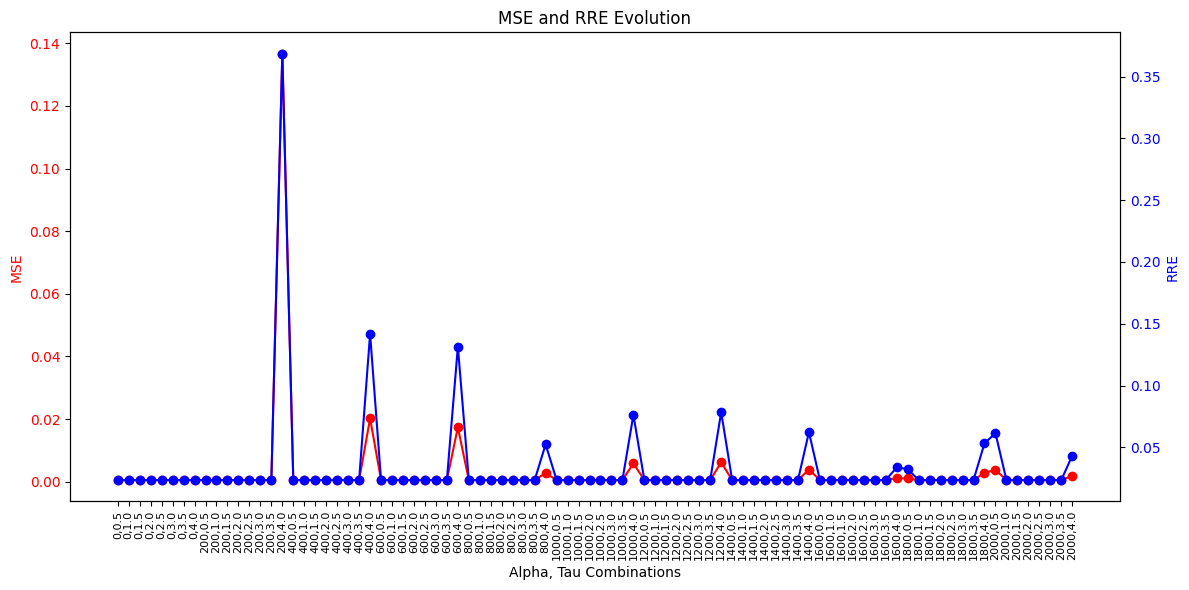

MSE: 0.0005609420946608743, RRE: 0.023607598423716212


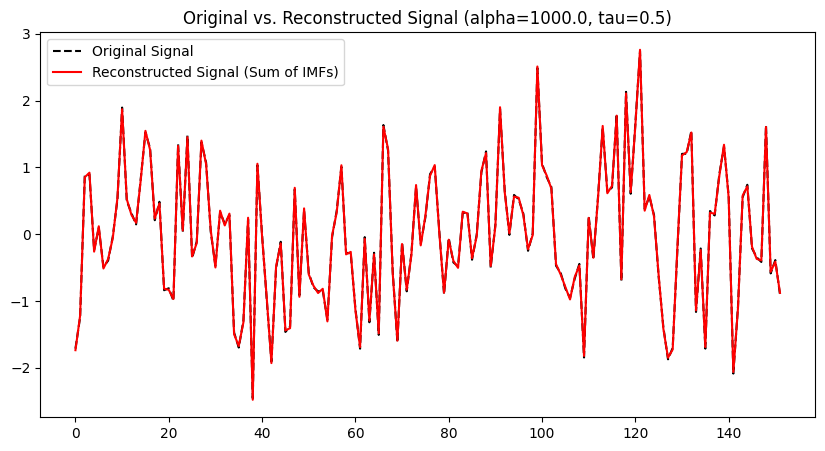

In [71]:
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Barcelona-HCPB_sub-027/Barcelona-HCPB_sub-027.npy")
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Bangalore-NIMHANS_sub-ODP203/Bangalore-NIMHANS_sub-ODP203.npy")
filename = "/pscratch/sd/p/pakmasha/MBBN_data/Bangalore-NIMHANS_sub-ODP203/Bangalore-NIMHANS_sub-ODP203.npy"

# y = time_series_data[20:20+100].T
y = time_series_data.T
ts_length = y.shape[1]
TR = repetition_time(filename)
print(f"TR = {TR}")

# average the time series across ROIs
sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec 

# VMD setting
f = sample_whole

# z-score normalization
f = (f - np.mean(f)) / np.std(f)

# VMD parameters
K = 4             # number of modes
DC = 0            # no DC part imposed
init = 0          # initialize omegas uniformly
tol = 1e-7        # convergence tolerance

alpha_values = np.arange(0, 2100, 200)  # bandwidth constraint
tau_values = np.arange(0.5, 4.5, 0.5)  # noise-tolerance
alpha_labels = []
tau_labels = []
alpha_tau_labels = []

mse_list = []
rre_list = []

# Run actual VMD code
for alpha in alpha_values:
    for tau in tau_values:
        print(f"\nAlpha = {alpha}, tau = {tau}")
        u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)

        print("Final IMF center frequencies (Hz):", omega[-1, :] / TR)
        
        # compare the sum of IMFs to the original signal
        reconstructed_signal = np.sum(u, axis=0)

        if len(f)%2:
           f = f[:-1]

        mse = np.mean((f - reconstructed_signal) ** 2)
        rre = np.linalg.norm(f - reconstructed_signal) / np.linalg.norm(f)
        print(f"MSE: {mse}, RRE: {rre}")

        mse_list.append(mse)
        rre_list.append(rre)
        alpha_labels.append(f"{alpha}")
        tau_labels.append(f"{tau}")
        alpha_tau_labels.append(f"{alpha},{tau}")

min_mse_index = np.argmin(mse_list)
min_rre_index = np.argmin(rre_list)
print(f"Min MSE: {mse_list[min_mse_index]}, parameters: {alpha_labels[min_mse_index]}, {tau_labels[min_mse_index]}")
print(f"Min RRE: {rre_list[min_rre_index]}, parameters: {alpha_labels[min_mse_index]}, {tau_labels[min_mse_index]}")

# plot the evolution of MSE and RRE
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(mse_list, 'r-o', label="MSE")
ax1.set_xlabel("Alpha, Tau Combinations")
ax1.set_ylabel("MSE", color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_xticks(range(len(alpha_tau_labels)))
ax1.set_xticklabels(alpha_tau_labels, rotation=90, fontsize=8)
ax1.set_title("MSE and RRE Evolution")

ax2 = ax1.twinx()
ax2.plot(rre_list, 'b-o', label="RRE")
ax2.set_ylabel("RRE", color='b')
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout()
plt.show()

# plot the original vs. reconstructed signal for the best (alpha, tau) pair
alpha = float(alpha_labels[min_mse_index])
tau = float(tau_labels[min_mse_index])
u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)
reconstructed_signal = np.sum(u, axis=0)
mse = np.mean((f - reconstructed_signal) ** 2)
rre = np.linalg.norm(f - reconstructed_signal) / np.linalg.norm(f)
print(f"MSE: {mse}, RRE: {rre}")

plt.figure(figsize=(10, 5))
plt.plot(f, 'k', linestyle="dashed", label="Original Signal")
plt.plot(reconstructed_signal, 'r', linestyle="solid", label="Reconstructed Signal (Sum of IMFs)")
plt.legend()
plt.title(f"Original vs. Reconstructed Signal (alpha={alpha}, tau={tau})")
plt.show()

T.shape: (152,)


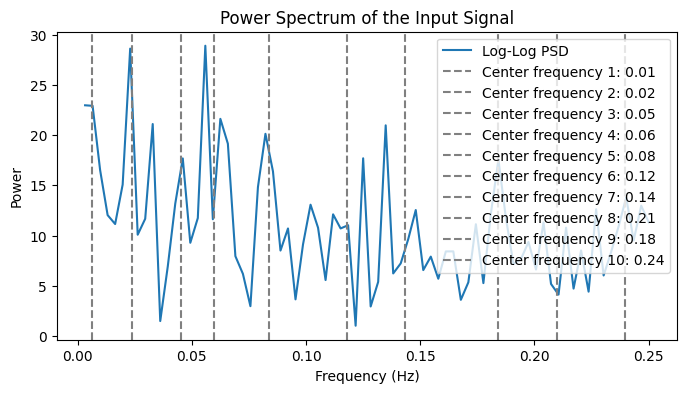

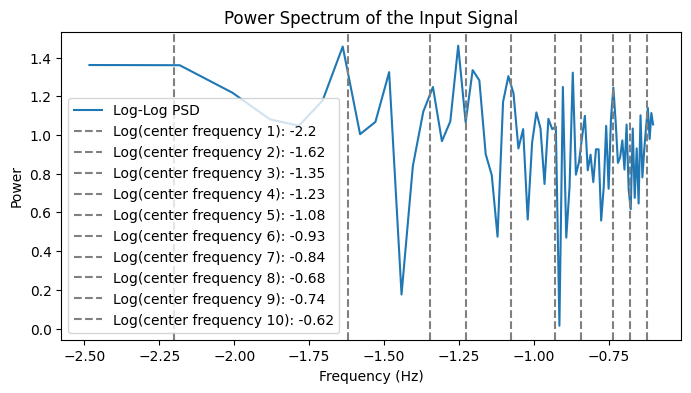

In [72]:
T = TimeSeries(f, sampling_interval=TR)
print(f"T.shape: {T.shape}")
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

plt.figure(figsize=(8, 4))
plt.plot(xdata, ydata, label="Log-Log PSD")  # Convert to Hz
for k in range(K):
    plt.axvline(x=omega[-1, k] / TR, color='gray', linestyle='--', label=f'Center frequency {k+1}: {np.round(omega[-1, k] / TR, 2)}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of the Input Signal")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(np.log10(xdata), np.log10(ydata), label="Log-Log PSD")  # Convert to Hz
for k in range(K):
    plt.axvline(x=np.log10(omega[-1, k] / TR), color='gray', linestyle='--', label=f'Log(center frequency {k+1}): {round(np.log10(omega[-1, k] / TR), 2)}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of the Input Signal")
plt.legend()
plt.show()

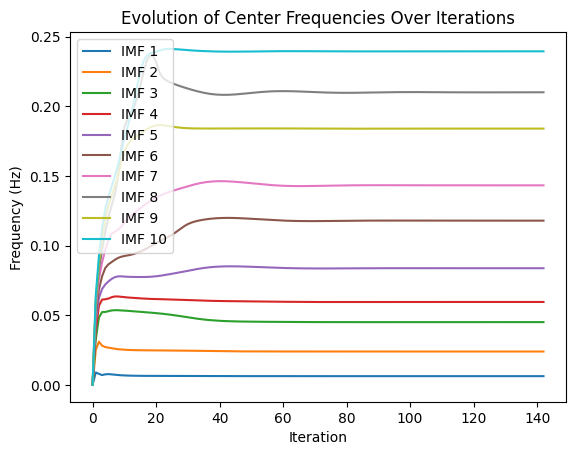

In [73]:
# plot frequency evolution over iterations
for k in range(K):
    plt.plot(omega[:, k] / TR, label=f'IMF {k+1}')
plt.legend()
plt.title("Evolution of Center Frequencies Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Frequency (Hz)")
plt.show()


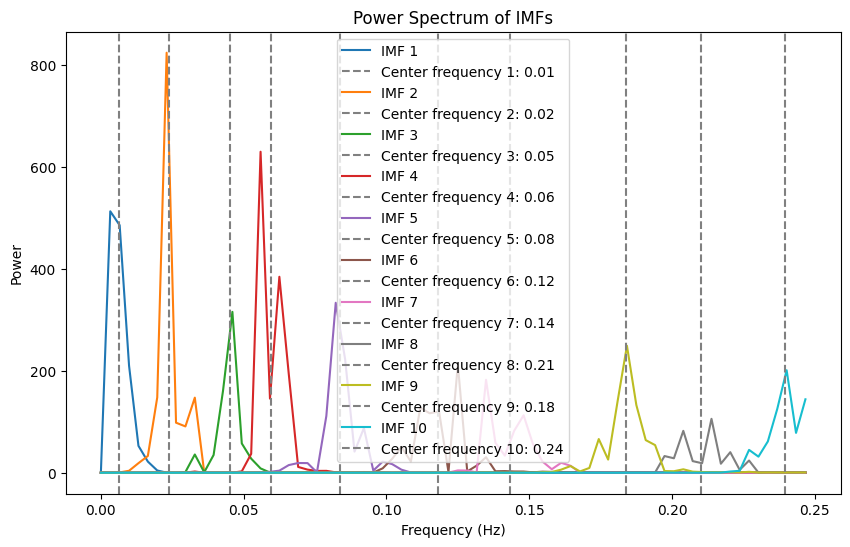

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def plot_imf_power_spectrum(u, fs):
    """
    Plots the power spectrum of each IMF to analyze its bandwidth.

    Parameters:
    - u: 2D numpy array of shape (K, N), where each row is an IMF.
    - fs: Sampling frequency of the original signal in Hz.
    """
    K, N = u.shape
    freq_axis = np.fft.fftfreq(N, d=1/fs)  # Frequency axis in Hz

    plt.figure(figsize=(10, 6))
    
    for k in range(K):
        u_hat = np.fft.fft(u[k, :])  # Compute FFT of the IMF
        power_spectrum = np.abs(u_hat) ** 2  # Compute power spectrum

        plt.plot(freq_axis[:N // 2], power_spectrum[:N // 2], label=f'IMF {k+1}')  # Plot positive frequencies
        plt.axvline(x=omega[-1, k] / TR, color='gray', linestyle='--', label=f'Center frequency {k+1}: {np.round(omega[-1, k] / TR, 2)}')

    
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title("Power Spectrum of IMFs")
    plt.legend()
    plt.show()

# Example usage:
plot_imf_power_spectrum(u, 1/TR)


In [75]:
import numpy as np

def compute_imf_bandwidths(u, fs, threshold=0.05):
    """
    Compute the bandwidths of IMFs using the Fourier spectrum directly from VMD output.
    
    This version correctly extracts frequency bounds in Hz, avoiding the issue of 
    symmetric zero-centered results.
    
    Parameters:
    u (ndarray): IMFs (shape: K x N, where K is the number of IMFs, N is the time samples).
    fs (float): Sampling frequency of the time series (Hz).
    threshold (float): Power threshold for frequency support (default 1% of max power).

    Returns:
    dict: Band cutoffs in Hz as { 'imf1_lb': ..., 'imf1_hb': ..., ... }
    """
    K, N = u.shape  # Number of IMFs and time samples
    f_N = fs / 2  # Nyquist frequency
    freqs = np.fft.fftfreq(N, d=1/fs)  # Compute frequencies WITHOUT shifting
    positive_freqs = freqs[:N//2]  # Keep only positive frequencies
    band_cutoffs = {}

    for k in range(K):
        # Compute the Fourier Transform of the IMF
        U_k = np.fft.fft(u[k, :])
        power_spectrum = np.abs(U_k) ** 2

        # Normalize power and apply threshold
        power_threshold = threshold * np.max(power_spectrum)
        
        # Extract frequency support only from the positive range
        freq_support = positive_freqs[power_spectrum[:N//2] > power_threshold]

        if len(freq_support) > 0:
            f_min = np.min(freq_support)  # Minimum frequency with significant power
            f_max = np.max(freq_support)  # Maximum frequency with significant power
        else:
            f_min, f_max = 0, 0  # In case no significant power is detected

        # Store the frequency cutoffs
        band_cutoffs[f'imf{k+1}_lb'] = max(0, f_min)  # Ensure non-negative frequencies
        band_cutoffs[f'imf{k+1}_hb'] = min(f_N, f_max)  # Ensure does not exceed Nyquist

        # Print results
        print(f"IMF {k+1}: Bandwidth = {f_max - f_min:.4f} Hz (Lower: {f_min:.4f} Hz, Upper: {f_max:.4f} Hz)")

    return band_cutoffs



band_cutoffs = compute_imf_bandwidths(u, 1/TR)

IMF 1: Bandwidth = 0.0099 Hz (Lower: 0.0033 Hz, Upper: 0.0132 Hz)
IMF 2: Bandwidth = 0.0132 Hz (Lower: 0.0197 Hz, Upper: 0.0329 Hz)
IMF 3: Bandwidth = 0.0197 Hz (Lower: 0.0329 Hz, Upper: 0.0526 Hz)
IMF 4: Bandwidth = 0.0132 Hz (Lower: 0.0526 Hz, Upper: 0.0658 Hz)
IMF 5: Bandwidth = 0.0329 Hz (Lower: 0.0691 Hz, Upper: 0.1020 Hz)
IMF 6: Bandwidth = 0.0329 Hz (Lower: 0.1020 Hz, Upper: 0.1349 Hz)
IMF 7: Bandwidth = 0.0296 Hz (Lower: 0.1349 Hz, Upper: 0.1645 Hz)
IMF 8: Bandwidth = 0.0296 Hz (Lower: 0.1974 Hz, Upper: 0.2270 Hz)
IMF 9: Bandwidth = 0.0296 Hz (Lower: 0.1645 Hz, Upper: 0.1941 Hz)
IMF 10: Bandwidth = 0.0197 Hz (Lower: 0.2270 Hz, Upper: 0.2467 Hz)


0.17434210526315788 0.24671052631578946


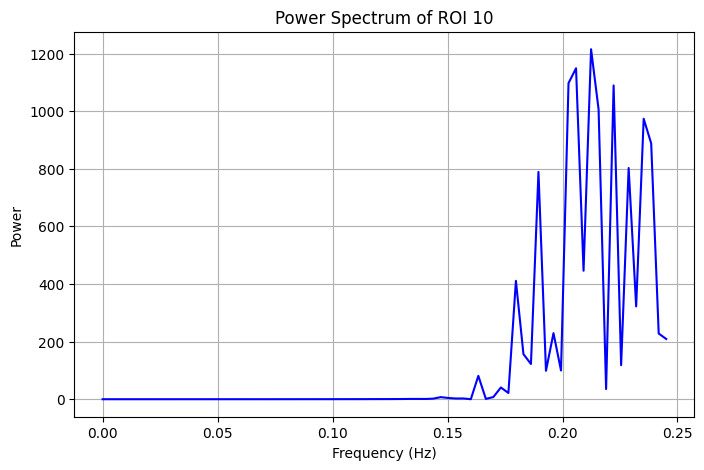

0.09868421052631579 0.17434210526315788


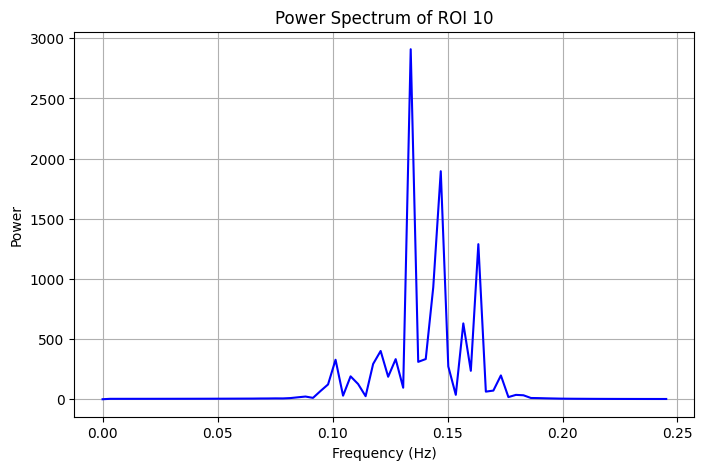

0.042763157894736836 0.09210526315789473


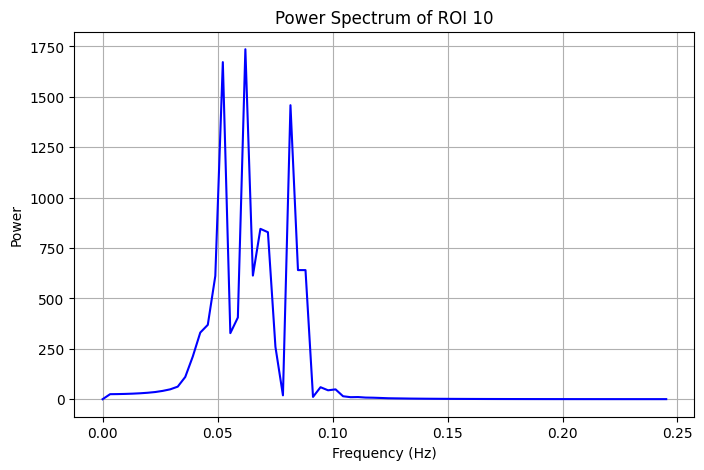

0.003289473684210526 0.03289473684210526


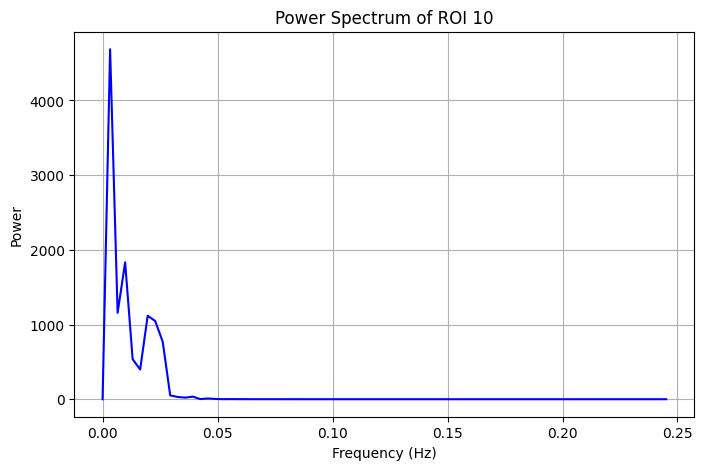

In [28]:
nyquist_freq = 1/(2*TR)

# average the time series across ROIs
sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec 

# VMD setting
f = sample_whole
f = (f - np.mean(f)) / np.std(f)  # z-score normalization
K = 4             # 3 modes
DC = 0             # no DC part imposed
init = 0           # initialize omegas uniformly
tol = 1e-7        # convergence tolerance
alpha = 100
tau = 3.5

# VMD
u, _, _ = VMD(f, alpha, tau, K, DC, init, tol)

import numpy as np

def compute_imf_bandwidths(u, fs, threshold=0.05):
    """
    Compute the bandwidths of IMFs using the Fourier spectrum directly from VMD output.
    
    This version correctly extracts frequency bounds in Hz, avoiding the issue of 
    symmetric zero-centered results.
    
    Parameters:
    u (ndarray): IMFs (shape: K x N, where K is the number of IMFs, N is the time samples).
    fs (float): Sampling frequency of the time series (Hz).
    threshold (float): Power threshold for frequency support (default 1% of max power).

    Returns:
    dict: Band cutoffs in Hz as { 'imf1_lb': ..., 'imf1_hb': ..., ... }
    """
    K, N = u.shape  # Number of IMFs and time samples
    f_N = fs / 2  # Nyquist frequency
    freqs = np.fft.fftfreq(N, d=1/fs)  # Compute frequencies WITHOUT shifting
    positive_freqs = freqs[:N//2]  # Keep only positive frequencies
    band_cutoffs = {}

    for k in range(K):
        # Compute the Fourier Transform of the IMF
        U_k = np.fft.fft(u[k, :])
        power_spectrum = np.abs(U_k) ** 2

        # Normalize power and apply threshold
        power_threshold = threshold * np.max(power_spectrum)
        
        # Extract frequency support only from the positive range
        freq_support = positive_freqs[power_spectrum[:N//2] > power_threshold]

        if len(freq_support) > 0:
            f_min = np.min(freq_support)  # Minimum frequency with significant power
            f_max = np.max(freq_support)  # Maximum frequency with significant power
        else:
            f_min, f_max = 0, 0  # In case no significant power is detected

        # Store the frequency cutoffs
        band_cutoffs[f'imf{k+1}_lb'] = max(0, f_min)  # Ensure non-negative frequencies
        band_cutoffs[f'imf{k+1}_hb'] = min(f_N, f_max)  # Ensure does not exceed Nyquist

        # Print results
        # print(f"IMF {k+1}: Bandwidth = {f_max - f_min:.4f} Hz (Lower: {f_min:.4f} Hz, Upper: {f_max:.4f} Hz)")

    return band_cutoffs


band_cutoffs = compute_imf_bandwidths(u, 1/TR)

from scipy.signal import butter, filtfilt
import numpy as np

def bandpass_filter_2d(data, lowcut, highcut, fs, order=4):
    """
    Applies a Butterworth bandpass filter to each ROI in a 2D time-series dataset.
    
    Parameters:
    - data: numpy array of shape (#ROIs, #timepoints), where each row is a time series for one ROI.
    - lowcut: Lower cutoff frequency (Hz).
    - highcut: Upper cutoff frequency (Hz).
    - fs: Sampling frequency (Hz) = 1 / TR.
    - order: Order of the Butterworth filter (default = 4).

    Returns:
    - filtered_data: numpy array of the same shape as 'data' with filtered time series.
    """
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design Butterworth bandpass filter
    b, a = butter(order, [low, high], btype='band')

    # Apply filter to each ROI (row-wise)
    filtered_data = np.array([filtfilt(b, a, roi_signal) for roi_signal in data])

    return filtered_data


import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum(time_series, TR, roi_index=0):
    """
    Plots the power spectrum of the selected ROI.

    Parameters:
    - time_series: numpy array of shape (#ROIs, #timepoints), containing fMRI or other time-series data.
    - TR: Repetition time (sampling interval in seconds).
    - roi_index: Index of the ROI to analyze (default = 0, first ROI).
    """

    # Extract the time-series for the selected ROI
    signal = time_series[roi_index, :]

    # Compute the Fourier Transform
    N = len(signal)  # Number of timepoints
    f_hat = np.fft.fft(signal)  # Compute FFT
    power_spectrum = np.abs(f_hat) ** 2  # Compute power (magnitude squared)

    # Compute frequency axis
    freqs = np.fft.fftfreq(N, d=TR)  # Frequencies in Hz

    # Keep only the positive frequencies
    positive_freqs = freqs[:N // 2]  # First half (positive freqs)
    positive_power = power_spectrum[:N // 2]  # First half (corresponding power)

    # Plot power spectrum
    plt.figure(figsize=(8, 5))
    plt.plot(positive_freqs, positive_power, color='b', linewidth=1.5)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.title(f"Power Spectrum of ROI {roi_index}")
    plt.grid(True)
    plt.show()


T1 = TimeSeries(y, sampling_interval=TR)
# FA1 = FilterAnalyzer(T1, lb = band_cutoffs['imf4_lb'], ub = band_cutoffs['imf4_hb'])
# imf1 = stats.zscore(FA1.filtered_boxcar.data, axis=1)
imf1 = bandpass_filter_2d(y, band_cutoffs['imf4_lb'], band_cutoffs['imf4_hb'], 1/TR)
imf1 = stats.zscore(imf1, axis=1)
print(band_cutoffs['imf4_lb'], band_cutoffs['imf4_hb'])
plot_power_spectrum(imf1, TR=2, roi_index=10)

# FA1 = FilterAnalyzer(T1, lb = band_cutoffs['imf3_lb'], ub = band_cutoffs['imf3_hb'])
# imf2 = stats.zscore(FA1.filtered_boxcar.data, axis=1)
imf2 = bandpass_filter_2d(y, band_cutoffs['imf3_lb'], band_cutoffs['imf3_hb'], 1/TR)
imf2 = stats.zscore(imf2, axis=1)
print(band_cutoffs['imf3_lb'], band_cutoffs['imf3_hb'])
plot_power_spectrum(imf2, TR=2, roi_index=10)

# FA1 = FilterAnalyzer(T1, lb = band_cutoffs['imf2_lb'], ub = band_cutoffs['imf2_hb'])
# imf3 = stats.zscore(FA1.filtered_boxcar.data, axis=1)
imf3 = bandpass_filter_2d(y, band_cutoffs['imf2_lb'], band_cutoffs['imf2_hb'], 1/TR)
imf3 = stats.zscore(imf3, axis=1)
print(band_cutoffs['imf2_lb'], band_cutoffs['imf2_hb'])
plot_power_spectrum(imf3, TR=2, roi_index=10)

# FA1 = FilterAnalyzer(T1, lb = band_cutoffs['imf1_lb'], ub = band_cutoffs['imf1_hb'])
# imf4 = stats.zscore(FA1.filtered_boxcar.data, axis=1)
imf4 = bandpass_filter_2d(y, band_cutoffs['imf1_lb'], band_cutoffs['imf1_hb'], 1/TR)
imf4 = stats.zscore(imf4, axis=1)
print(band_cutoffs['imf1_lb'], band_cutoffs['imf1_hb'])
plot_power_spectrum(imf4, TR=2, roi_index=10)


# # IMF1
# if nyquist_freq > 0.185:
#     lower_bound = band_cutoffs['imf4_lb']
#     upper_bound = band_cutoffs['imf4_hb']
#     print(lower_bound, upper_bound)
#     T1 = TimeSeries(y, sampling_interval=TR)  # creates a time-series object from y
#     FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
#     imf1 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
#     imf2_4 = FA1.data-FA1.filtered_boxcar.data
# else: # filter out the whole band
#     imf1 = np.zeros_like(y) 
#     imf2_4 = y

# # IMF2
# lower_bound = band_cutoffs['imf3_lb']
# upper_bound = band_cutoffs['imf3_hb']
# print(lower_bound, upper_bound)
# T1 = TimeSeries(imf2_4, sampling_interval=TR)  # creates a time-series object from y
# FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
# imf2 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
# imf3_4 = FA1.data-FA1.filtered_boxcar.data

# # IMF3
# lower_bound = band_cutoffs['imf2_lb']
# upper_bound = band_cutoffs['imf2_hb']
# print(lower_bound, upper_bound)
# T1 = TimeSeries(imf3_4, sampling_interval=TR)  # creates a time-series object from y
# S_original = SpectralAnalyzer(T1)
# FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
# imf3 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)
# imf4 = FA1.data-FA1.filtered_boxcar.data

# # IMF4
# lower_bound = band_cutoffs['imf1_lb']
# upper_bound = band_cutoffs['imf1_hb']
# print(lower_bound, upper_bound)
# T1 = TimeSeries(imf4, sampling_interval=TR)  # creates a time-series object from y
# S_original = SpectralAnalyzer(T1)
# FA1 = FilterAnalyzer(T1, lb = lower_bound, ub = upper_bound)  # filters the time-series data T1 by applying the lower and upper bounds
# imf4 = stats.zscore(FA1.filtered_boxcar.data, axis=1)  # z-score normalization along the rows (i.e., for each ROI) on the filtered time-series data ((x - mean) / sd)


# # Function to visualize the original time series
# def visualize_time_series(time_series, sampling_interval, title="Time Series"):
#     # Generate time points based on the sampling interval and length of the series
#     time_points = [i * sampling_interval for i in range(len(time_series))]
    
#     plt.figure(figsize=(8, 5))
#     plt.plot(time_points, time_series, label='Time Series', linewidth=1.5, color='green')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Signal Intensity')
#     plt.title(title)
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.legend()
#     plt.show()

# visualize_time_series(imf1[0,:], TR)
# visualize_time_series(imf2[0,:], TR)
# visualize_time_series(imf3[0,:], TR)
# visualize_time_series(imf4[0,:], TR)

In [29]:
# import numpy as np
# from scipy.signal import hilbert
# import seaborn as sns


# def visualize_delta_f_norm_density(delta_f_norm_values):
#     """
#     Visualizes the density function of delta_f_norm values using a KDE plot.

#     Parameters:
#     delta_f_norm_values (list or ndarray): Array of delta_f_norm values for each IMF.
#     """
#     plt.figure(figsize=(8, 5))
#     sns.kdeplot(delta_f_norm_values, fill=True, bw_adjust=0.5)
#     plt.xlabel("Delta f (Normalized)")
#     plt.ylabel("Density")
#     plt.title("Density Function of Delta f (Maximum Frequency Deviation)")
#     plt.grid(True)
#     plt.show()

# def compute_imf_bandwidths(u, omega, fs):
#     """
#     Compute the bandwidths of IMFs using normalized frequency units and convert the cutoffs to Hz at the end.
    
#     Parameters:
#     u (ndarray): IMFs (shape: K x N, where K is the number of IMFs, N is the time samples).
#     omega (ndarray): Center frequencies of each IMF from VMD (shape: [# of iterations, K], where K is the number of IMFs).
#     fs (float): Real-world sampling frequency in Hz.

#     Returns:
#     dict: Band cutoffs in Hz as { 'imf1_lb': ..., 'imf1_hb': ..., ... }
#     """
#     K, N = u.shape  # Number of IMFs and time samples
#     f_N = 0.5  # Nyquist frequency in normalized units
#     T = N / fs  # Total duration of the signal in seconds
#     band_cutoffs = {}

#     for k in range(K):
#         # Compute the analytic signal using Hilbert transform
#         analytic_signal = hilbert(u[k, :])
        
#         # Compute instantaneous phase and frequency (in normalized units)
#         instantaneous_phase = np.unwrap(np.angle(analytic_signal))
#         instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi)  
        
#         # Extract the last converged center frequency for mode k
#         omega_k_norm = omega[-1, k]  

#         # Compute Delta f (Maximum deviation of instantaneous frequency, in normalized units)
#         delta_f_norm = np.max(np.abs(instantaneous_frequency - omega_k_norm))
#         # delta_f_norm = np.percentile(np.abs(instantaneous_frequency - omega_k_norm), 95)
#         visualize_delta_f_norm_density(instantaneous_frequency - omega_k_norm)
        
#         # Compute f_FM as excursion rate (in normalized units)
#         # f_fm_norm = delta_f_norm / T 
#         f_fm_norm = np.mean(np.abs(np.gradient(instantaneous_frequency, 1/fs)))

#         # Compute f_AM (Highest frequency in amplitude envelope spectrum, in normalized units)
#         amplitude_envelope = np.abs(analytic_signal)
#         envelope_spectrum = np.fft.fftshift(np.fft.fft(amplitude_envelope))
#         freqs_norm = np.fft.fftshift(np.fft.fftfreq(N, d=1/fs)) / (fs / 2)  # Normalize frequency axis
#         # f_am_norm = np.max(freqs_norm[np.abs(envelope_spectrum) > 0.01 * np.max(np.abs(envelope_spectrum))])  # Thresholding small values
#         spectrum_power = np.abs(envelope_spectrum) ** 2
#         cumulative_power = np.cumsum(spectrum_power) / np.sum(spectrum_power)
#         f_am_norm = freqs_norm[np.argmax(cumulative_power > 0.95)]

#         # Compute bandwidth using the equation from the VMD paper (all in normalized units)
#         bandwidth_norm = 2 * (delta_f_norm + f_fm_norm + f_am_norm)

#         # Convert lower and upper boundaries to Hz
#         imf_lb_hz = (omega_k_norm - bandwidth_norm / 2) * fs  # Convert to Hz
#         imf_hb_hz = (omega_k_norm + bandwidth_norm / 2) * fs  # Convert to Hz

#         # Ensure boundaries do not go negative or exceed Nyquist
#         imf_lb_hz = max(0, imf_lb_hz)
#         imf_hb_hz = min(fs / 2, imf_hb_hz)

#         # Store the results
#         band_cutoffs[f'imf{k+1}_lb'] = imf_lb_hz
#         band_cutoffs[f'imf{k+1}_hb'] = imf_hb_hz

#         # Print the bandwidth in Hz
#         print(f"\nIMF {k+1}: Bandwidth = {bandwidth_norm * fs:.6f} Hz (Center: {omega_k_norm * fs:.6f} Hz")
#         print(f"delta_f in Hz: {delta_f_norm * fs:.4f}")
#         print(f"f_fm_norm in Hz:: {f_fm_norm * fs:.4f}")
#         print(f"f_am_norm in Hz: {f_am_norm * fs:.4f}")

#     return band_cutoffs



# compute_imf_bandwidths(u, omega, 1/TR)

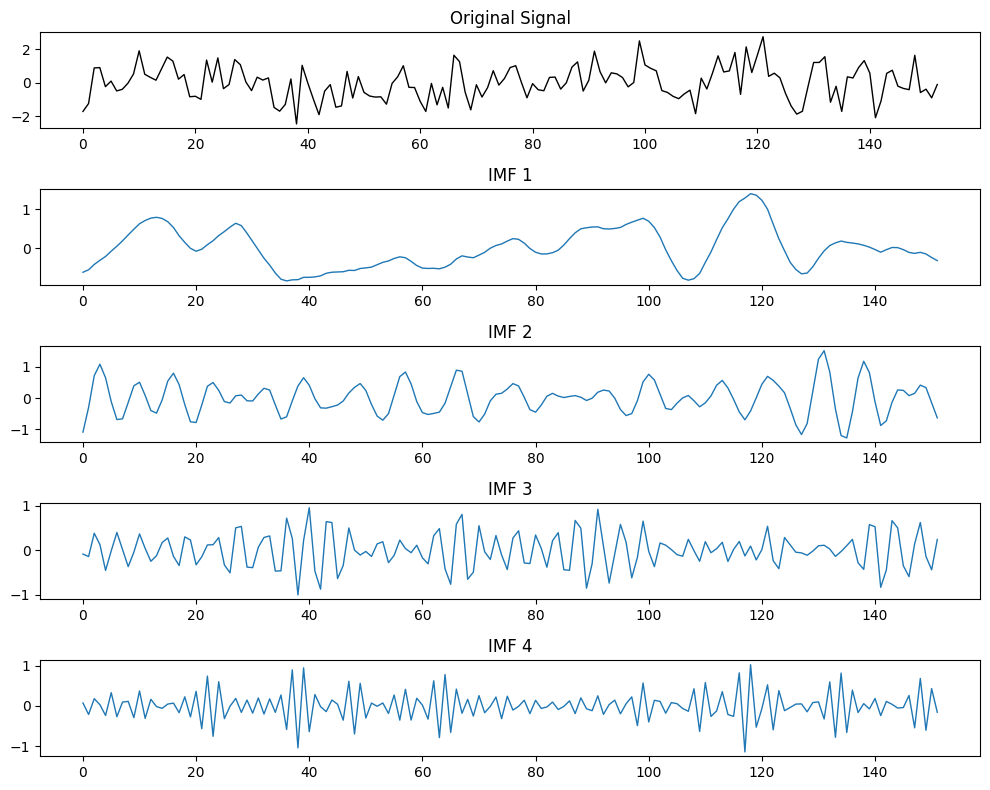

In [30]:
# plot all IMFs
K, N = u.shape  # Number of IMFs and timepoints
    
plt.figure(figsize=(10, 8))

# Plot the original signal
plt.subplot(K + 1, 1, 1)
plt.plot(f, 'k', linewidth=1)
plt.title("Original Signal")

# Plot each IMF
for k in range(K):
    plt.subplot(K + 1, 1, k + 2)
    plt.plot(u[k, :], linewidth=1)
    plt.title(f"IMF {k + 1}")

plt.tight_layout()
plt.show()

### Variational Mode Decomposition (ROI time series, one subject)

In [224]:
time_series_data = np.load("/scratch/connectome/pakmasha99/ENIGMA_OCD_MBBN/MBBN_data/Barcelona-HCPB_sub-027/Barcelona-HCPB_sub-027.npy")
# time_series_data = np.load("/scratch/connectome/pakmasha99/ENIGMA_OCD_MBBN/MBBN_data/Bangalore-NIMHANS_sub-ODP203/Bangalore-NIMHANS_sub-ODP203.npy")
y = time_series_data.T
ts_length = y.shape[1]
num_of_rois = y.shape[0]

# VMD parameters
K = 4             # modes
DC = 0             # no DC part imposed
init = 0           # initialize omegas uniformly
tol = 1e-7        # convergence tolerance
alpha = 100
tau = 3.5

# Initialize IMFs
imf1 = np.zeros((y.shape[0], y.shape[1]))
imf2 = np.zeros((y.shape[0], y.shape[1]))
imf3 = np.zeros((y.shape[0], y.shape[1]))
imf4 = np.zeros((y.shape[0], y.shape[1]))

for roi in range(num_of_rois):
    print(f"ROI number: {roi}")

    f = y[roi,:] # ROI time series
    f = (f - np.mean(f)) / np.std(f)  # z-score normalization
    f_hat = np.fft.fftshift((np.fft.fft(f)))  # transform signal to the Fourier domain

    # Run actual VMD code
    u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)

    print("Final IMF center frequencies (Hz):", omega[-1, :] / (2 * np.pi))
    # print("Final IMF center frequencies (Hz):", omega[-1, :] / (2 * np.pi * TR))

    # compare the sum of IMFs to the original signal
    reconstructed_signal = np.sum(u, axis=0)

    if len(f)%2:
        f = f[:-1]

    mse = np.mean((f - reconstructed_signal) ** 2)
    rre = np.linalg.norm(f - reconstructed_signal) / np.linalg.norm(f)
    print(f"MSE: {mse}, RRE: {rre}")

    # add the ROI modes to the total IMFs
    imf1[roi, :] = u[0, :]
    imf2[roi, :] = u[1, :]
    imf3[roi, :] = u[2, :]
    imf4[roi, :] = u[3, :]

ROI number: 0
Final IMF center frequencies (Hz): [0.00844304 0.03110524 0.05298573 0.07233974]
MSE: 0.0005316949115361368, RRE: 0.02305851060966724
ROI number: 1
Final IMF center frequencies (Hz): [0.00673781 0.0213679  0.04205576 0.06876904]
MSE: 0.001851236507158921, RRE: 0.04302599803791797
ROI number: 2
Final IMF center frequencies (Hz): [0.00789603 0.02551985 0.04492814 0.06927769]
MSE: 0.0005031343456569407, RRE: 0.022430656380430347
ROI number: 3
Final IMF center frequencies (Hz): [0.00746733 0.02332282 0.03765419 0.06465421]
MSE: 0.0010193402433171718, RRE: 0.03192710828304329
ROI number: 4
Final IMF center frequencies (Hz): [0.00703833 0.02624846 0.04466003 0.06962908]
MSE: 0.0005201782739164856, RRE: 0.022807417081214733
ROI number: 5
Final IMF center frequencies (Hz): [0.0087301  0.02817122 0.05048251 0.07295806]
MSE: 0.0001940484936443082, RRE: 0.013930128988789306
ROI number: 6
Final IMF center frequencies (Hz): [0.00665563 0.02100403 0.0432678  0.06756557]
MSE: 0.00017573

In [228]:
print(f"IMF1: {imf1[:10,:10]}")
print(f"\nIMF2: {imf2[:10,:10]}")

IMF1: [[-0.49939669 -0.4562696  -0.35343114 -0.22428411 -0.0831619  -0.01514169
  -0.02023754  0.01815743  0.00231492 -0.1190053 ]
 [-1.24133215 -1.12927334 -0.95677933 -0.73820191 -0.51347798 -0.3230359
  -0.12183247  0.08082707  0.22144916  0.28048093]
 [-0.85099614 -0.73025146 -0.47328074 -0.16882879  0.07565785  0.20924061
   0.22547018  0.13768675 -0.14226668 -0.50450882]
 [-0.7709007  -0.70034131 -0.527041   -0.33051505 -0.14300547  0.08280091
   0.30353494  0.49946543  0.62292463  0.58712859]
 [-0.3971796  -0.38044953 -0.34797989 -0.28063481 -0.13807961  0.04998427
   0.20021096  0.28690844  0.2873343   0.19249364]
 [-0.78540691 -0.80191857 -0.77606961 -0.69594085 -0.52261439 -0.22252593
   0.23049106  0.81556935  1.35787667  1.73617547]
 [-0.49215449 -0.44944705 -0.32638132 -0.19615472 -0.05585038  0.1400239
   0.35829504  0.57169445  0.72582887  0.73939747]
 [-0.48800227 -0.45402642 -0.39833435 -0.31298295 -0.17657605  0.00728793
   0.25434713  0.50433862  0.71926745  0.872986

### Variational Mode Decomposition (averaged time series, all subjects)

#### K = 4

In [220]:
# Base path for data
base_path = "/scratch/connectome/pakmasha99/ENIGMA_OCD_MBBN/MBBN_data/"

# VMD parameters
K = 4             # modes
DC = 0             # no DC part imposed
init = 0           # initialize omegas uniformly
tol = 1e-7        # convergence tolerance
alpha_values = np.arange(100, 1100, 100)  # bandwidth constraint
tau_values = np.arange(0.5, 4.5, 0.5)  # noise-tolerance

# Store results for all (alpha, tau) pairs
results = {}

# Tracking best parameters across all subjects
best_mse = float('inf')
best_rre = float('inf')
best_alpha_mse, best_tau_mse = None, None
best_alpha_rre, best_tau_rre = None, None

for alpha in alpha_values:
    for tau in tau_values:
        print(f"\nAlpha = {alpha}, tau = {tau}")

        # Initialize metrics
        total_mse = 0
        total_rre = 0
        subject_count = 0

        # Process each subject
        for subject_id in os.listdir(base_path):
            subject_path = os.path.join(base_path, subject_id)
            subject_file = os.path.join(subject_path, f"{subject_id}.npy")

            time_series_data = np.load(subject_file)
            y = time_series_data.T
            ts_length = y.shape[1]

            # average the time series across ROIs
            sample_whole = np.zeros(ts_length,)
            intermediate_vec = y.shape[0]

            for i in range(intermediate_vec):
                sample_whole+=y[i]

            sample_whole /= intermediate_vec 
            f = sample_whole
            f = (f - np.mean(f)) / np.std(f)  # z-score normalization
            f_hat = np.fft.fftshift((np.fft.fft(f)))  # transform signal to the Fourier domain

            # Run actual VMD code
            u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)
            
            # compare the sum of IMFs to the original signal
            reconstructed_signal = np.sum(u, axis=0)

            if len(f)%2:
                f = f[:-1]

            mse = np.mean((f - reconstructed_signal) ** 2)
            rre = np.linalg.norm(f - reconstructed_signal) / np.linalg.norm(f)

            # Accumulate metrics
            total_mse += mse
            total_rre += rre
            subject_count += 1

            if subject_count % 500 == 0:
                print(f"Total MSE: {total_mse}, total RRE: {total_rre}, subject count: {subject_count}")

        # Compute mean errors
        mean_mse = total_mse / subject_count if subject_count > 0 else float('inf')
        mean_rre = total_rre / subject_count if subject_count > 0 else float('inf')

        # Store results for this (alpha, tau) pair
        results[(alpha, tau)] = {
            "mean_mse": mean_mse,
            "mean_rre": mean_rre,
            "subject_count": subject_count
        }
                    
        # Update best parameters
        if mean_mse < best_mse:
            best_mse = mean_mse
            best_alpha_mse, best_tau_mse = alpha, tau
        if mean_rre < best_rre:
            best_rre = mean_rre
            best_alpha_rre, best_tau_rre = alpha, tau

            print(f"updated best MSE: {best_mse}")
            print(f"updated best RRE: {best_rre}")

# Print final results
print(f"\nBest (alpha, tau) for MSE: ({best_alpha_mse}, {best_tau_mse}) with mean MSE={best_mse:.6f}")
print(f"\nBest (alpha, tau) for RRE: ({best_alpha_rre}, {best_tau_rre}) with mean RRE={best_rre:.6f}")


Alpha = 100, tau = 0.5
Total MSE: 0.4849106762410787, total RRE: 11.338341913575857, subject count: 500
Total MSE: 0.9444509155055656, total RRE: 22.852557155728412, subject count: 1000
Total MSE: 1.4646751441252484, total RRE: 34.611759144374886, subject count: 1500
Total MSE: 2.017951785339042, total RRE: 47.11740911674266, subject count: 2000
updated best MSE: 0.0010091994797735554
updated best RRE: 0.023576362867590538

Alpha = 100, tau = 1.0
Total MSE: 0.48425714572383977, total RRE: 11.308336826636584, subject count: 500
Total MSE: 0.9434454573649448, total RRE: 22.803397203342886, subject count: 1000
Total MSE: 1.4636688475125899, total RRE: 34.562464894599465, subject count: 1500
Total MSE: 2.01694773698943, total RRE: 47.06801654647067, subject count: 2000
updated best MSE: 0.0010087194798008641
updated best RRE: 0.023552764936319193

Alpha = 100, tau = 1.5
Total MSE: 0.48425576033558737, total RRE: 11.308311052693648, subject count: 500
Total MSE: 0.943443637808286, total RR

KeyboardInterrupt: 

In [221]:
# Print final results
print(f"\nBest (alpha, tau) for MSE: ({best_alpha_mse}, {best_tau_mse}) with mean MSE={best_mse:.6f}")
print(f"\nBest (alpha, tau) for RRE: ({best_alpha_rre}, {best_tau_rre}) with mean RRE={best_rre:.6f}")


Best (alpha, tau) for MSE: (100, 3.5) with mean MSE=0.001009

Best (alpha, tau) for RRE: (100, 3.5) with mean RRE=0.023553


### Sequence length zero-padding

In [51]:
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Barcelona-HCPB_sub-027/Barcelona-HCPB_sub-027.npy")
time_series_data = np.load("/pscratch/sd/p/pakmasha/MBBN_data/Bangalore-NIMHANS_sub-ODP203/Bangalore-NIMHANS_sub-ODP203.npy")
filename = "/pscratch/sd/p/pakmasha/MBBN_data/Bangalore-NIMHANS_sub-ODP203/Bangalore-NIMHANS_sub-ODP203.npy"
subj_name = filename.split('/')[-2]
print(f"subj_name: {subj_name}")

sequence_length = 500
y = time_series_data[20:].T  # FOR SEQUENCE LENGTH PADDING EXPERIMENT
print(f"y.shape: {y.shape}")
        
if y.shape[1] > sequence_length:
    y = y[:, :sequence_length]

ts_length = y.shape[1]   # temporal padding
pad = sequence_length - ts_length
site = subj_name.split('_')[-2] 
TR = repetition_time(site)
print(f"site: {site}, TR: {TR}")

# average the time series across ROIs
sample_whole = np.zeros(ts_length,)
intermediate_vec = y.shape[0]

for i in range(intermediate_vec):
    sample_whole+=y[i]

sample_whole /= intermediate_vec 
print(f"sample_whole shape: {sample_whole.shape}")

# VMD setting
f = sample_whole
f = (f - np.mean(f)) / np.std(f)  # z-score normalization
K = 4             # number of modes modes
DC = 0             # no DC part imposed
init = 0           # initialize omegas uniformly
tol = 1e-7        # convergence tolerance
alpha = 100
tau = 3.5

# VMD
u, _, omega = VMD(f, alpha, tau, K, DC, init, tol)
print(f"u.shape: {u.shape}")

subj_name: Bangalore-NIMHANS_sub-ODP203
y.shape: (316, 133)
site: Bangalore-NIMHANS, TR: 2
sample_whole shape: (133,)
u.shape: (4, 132)


T.shape: (133,)


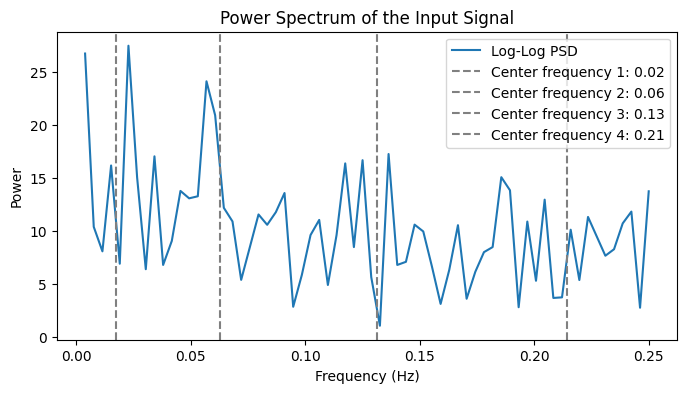

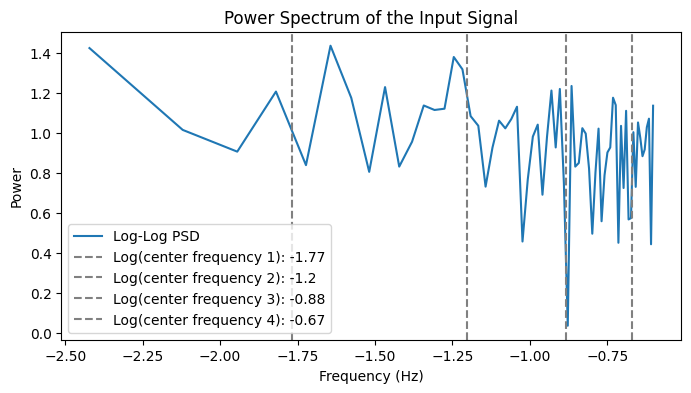

In [52]:
T = TimeSeries(f, sampling_interval=TR)
print(f"T.shape: {T.shape}")
S_original = SpectralAnalyzer(T)

# Lorentzian function fitting
xdata = np.array(S_original.spectrum_fourier[0][1:])
ydata = np.abs(S_original.spectrum_fourier[1][1:])

plt.figure(figsize=(8, 4))
plt.plot(xdata, ydata, label="Log-Log PSD")  # Convert to Hz
for k in range(K):
    plt.axvline(x=omega[-1, k] / TR, color='gray', linestyle='--', label=f'Center frequency {k+1}: {np.round(omega[-1, k] / TR, 2)}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of the Input Signal")
plt.legend()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(np.log10(xdata), np.log10(ydata), label="Log-Log PSD")  # Convert to Hz
for k in range(K):
    plt.axvline(x=np.log10(omega[-1, k] / TR), color='gray', linestyle='--', label=f'Log(center frequency {k+1}): {round(np.log10(omega[-1, k] / TR), 2)}')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of the Input Signal")
plt.legend()
plt.show()

In [63]:
band_cutoffs = compute_imf_bandwidths(u, 1/TR)

if band_cutoffs['imf4_lb'] > band_cutoffs['imf4_hb']:
    raise ValueError(f"band_cutoffs['imf4_lb'] {band_cutoffs['imf4_lb']} is larger than band_cutoffs['imf4_hb'] {band_cutoffs['imf4_hb']} for subject {subj_name}")
elif band_cutoffs['imf4_lb'] == band_cutoffs['imf4_hb']:
    imf1 = np.zeros((y.shape[0], y.shape[1]))
else:
    imf1 = bandpass_filter_2d(y, band_cutoffs['imf4_lb'], band_cutoffs['imf4_hb'], 1/TR)
    imf1 = stats.zscore(imf1, axis=1)

if band_cutoffs['imf3_lb'] > band_cutoffs['imf3_hb']:
    raise ValueError(f"band_cutoffs['imf3_lb'] {band_cutoffs['imf3_lb']} is larger than band_cutoffs['imf3_hb'] {band_cutoffs['imf3_hb']} for subject {subj_name}")
elif band_cutoffs['imf3_lb'] == band_cutoffs['imf3_hb']:
    imf2 = np.zeros((y.shape[0], y.shape[1]))
else:
    imf2 = bandpass_filter_2d(y, band_cutoffs['imf3_lb'], band_cutoffs['imf3_hb'], 1/TR)
    imf2 = stats.zscore(imf2, axis=1)

if band_cutoffs['imf2_lb'] > band_cutoffs['imf2_hb']:
    raise ValueError(f"band_cutoffs['imf2_lb'] {band_cutoffs['imf2_lb']} is larger than band_cutoffs['imf2_hb'] {band_cutoffs['imf2_hb']} for subject {subj_name}")
elif band_cutoffs['imf2_lb'] == band_cutoffs['imf2_hb']:
    imf3 = np.zeros((y.shape[0], y.shape[1]))
else:
    imf3 = bandpass_filter_2d(y, band_cutoffs['imf2_lb'], band_cutoffs['imf2_hb'], 1/TR)
    imf3 = stats.zscore(imf3, axis=1)

if band_cutoffs['imf1_lb'] > band_cutoffs['imf1_hb']:
    raise ValueError(f"band_cutoffs['imf1_lb'] {band_cutoffs['imf1_lb']} is larger than band_cutoffs['imf1_hb'] {band_cutoffs['imf1_hb']} for subject {subj_name}")
elif band_cutoffs['imf1_lb'] == band_cutoffs['imf1_hb']:
    imf4 = np.zeros((y.shape[0], y.shape[1]))
else:
    imf4 = bandpass_filter_2d(y, band_cutoffs['imf1_lb'], band_cutoffs['imf1_hb'], 1/TR)
    imf4 = stats.zscore(imf4, axis=1)

print(f"imf1.shape: {imf1.shape}")

imf1 = F.pad(torch.from_numpy(imf1), (0, pad), "constant", 0).T.float()
imf2 = F.pad(torch.from_numpy(imf2), (0, pad), "constant", 0).T.float()
imf3 = F.pad(torch.from_numpy(imf3), (0, pad), "constant", 0).T.float()
imf4 = F.pad(torch.from_numpy(imf4), (0, pad), "constant", 0).T.float()

print(f"imf1.shape after padding and transpose: {imf1.shape}")

if sequence_length > ts_length:
    mask = (imf1 != 0).float()  # Create mask where 1 means valid and 0 means padding
    print(f"mask.shape: {mask.shape}")
    print(f"First column of the mask:\n {mask[:,0]}")
else:
    mask = None
    print(f"mask: {mask}")


mask = torch.from_numpy(np.zeros((8, 500, 316)))  # shape: (batch, seq_len, ROI)
print(f"Synthetic mask shape: {mask.shape}")

# temporal mask
time_mask = (mask.sum(dim=-1) != 0).long()  # shape: (batch, seq_len)
print(f"\nTemporal mask shape: {time_mask.shape}")
print(f"Temporal mask: \n{time_mask}")

roi_mask = (mask.sum(dim=1) != 0).long()  # shape: (batch, ROI)
print(f"\nroi_mask.shape: {roi_mask.shape}")

spatial_mask = roi_mask.unsqueeze(1).unsqueeze(1) # shape: (batch, 1, 1, ROI)
print(f"\nspatial mask shape: {spatial_mask.shape}")

imf1.shape: (316, 133)
imf1.shape after padding and transpose: torch.Size([500, 316])
mask.shape: torch.Size([500, 316])
First column of the mask:
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 